In [1]:
import numpy as np
from time import time
from matplotlib import pyplot as plt
import pandas as pd
from sklearn import datasets, metrics, svm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, MaxPooling1D, Conv2D, Reshape
from tensorflow.keras import losses, optimizers
import os, sys, csv
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import motor
sys.path.append('../../')
from data_loader import get_dataset, get_label

hyperparameters

In [2]:
epoch_size = 200
batch_size = 150
repeat = 100

### Load Data

In [3]:
data_dim_MFCC = 13
# trSampleRatio = 0.85
# data_dim_CWT = 13
# data_dim_DWT = 13

data_cfg = {
    "dataType" : "MFCC",
    "division" : "whole",
    "dataDimension" : data_dim_MFCC
}

In [4]:
name = data_cfg["dataType"]

In [5]:
data_whole = get_dataset(data_cfg)

data_MFCC_only_whole.shape: (150, 13)


#### 1. not divided

In [6]:
n_features = 1
# data_whole = motor.load_MFCC_whole()
# data_whole = motor.load_CWT_whole()

#### 2. transient phase

In [7]:
# n_features = 1
# data_whole = motor.load_MFCC_transient()
# data_whole = motor.load_CWT_transient()

#### 3. steady-state phase

In [8]:
# n_features = 1
# data_whole = motor.load_MFCC_steady()

#### 4. both transient & steady-state phase

In [9]:
# n_features = 2
# data_MFCC_only_steady = motor.load_MFCC_steady()
# data_MFCC_only_transient = motor.load_MFCC_transient()
# data_whole = np.append(data_MFCC_only_steady, data_MFCC_only_transient, 1)

In [10]:
y_whole = get_label()
# y_whole = np.append(np.zeros(100),np.ones(50))    # 0 for normal, 1 for defect

### CNN classifier

In [11]:
def buildCNNmodel():
    n_channel = [16, 20, 30]
    #with tf.device('/gpu:1'):
    tf.keras.backend.clear_session()
    model = Sequential()
    model.add(Conv1D(filters = n_channel[0], kernel_size = 3, activation = 'relu', input_shape = [motor.data_dim_MFCC, n_features], padding = 'same'))
    model.add(Conv1D(filters = n_channel[0], kernel_size = 3, activation = 'relu', padding = 'valid'))
    model.add(Conv1D(filters = n_channel[0], kernel_size = 3, activation = 'relu', padding = 'valid'))
    model.add(Flatten(name="feature_extraction"))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(loss = losses.mean_squared_error, optimizer = optimizers.Adam(0.001))

    Wsave = model.get_weights()
    print(model.summary())
    return model, Wsave

In [12]:
model, Wsave = buildCNNmodel()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 13, 16)            64        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 11, 16)            784       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 9, 16)             784       
_________________________________________________________________
feature_extraction (Flatten) (None, 144)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 145       
Total params: 1,777
Trainable params: 1,777
Non-trainable params: 0
_________________________________________________________________
None


### MLP classifier

In [13]:
# def buildMLPmodel():
#     n_fc = [16, 8]
#     #with tf.device('/gpu:1'):
#     tf.keras.backend.clear_session()
#     model = Sequential()

#     model.add(Dense(n_fc[0], activation = 'relu', input_dim = motor.data_dim_MFCC * n_features))
#     model.add(Dense(n_fc[0], activation = 'relu'))
#     model.add(Dense(n_fc[0], activation = 'relu'))
#     model.add(Dense(n_fc[0], activation = 'relu'))
#     model.add(Dense(n_fc[1], activation = 'relu', name="feature_extraction"))
#     model.add(Dense(1, activation = 'sigmoid'))

#     model.compile(loss = losses.mean_squared_error, optimizer = optimizers.Adam(0.001))

#     Wsave = model.get_weights()
#     print(model.summary())
#     return model, Wsave

In [14]:
# model, Wsave = buildMLPmodel()

### CNN training

In [15]:
AUCs = np.array([])
for repeat in range(100):
    [train_data, train_label, test_data, test_label] = motor.resampleData(data_whole, y_whole)
    model.set_weights(Wsave)
    [y_predictions, y_trues] = motor.fitClassifier_y_pred(model, train_data,train_label,test_data,test_label, epoch_size, batch_size)
    
    fpr, tpr, thresholds = metrics.roc_curve(y_trues, y_predictions, pos_label=1)
    AUC = metrics.auc(fpr, tpr)
    AUCs = np.append(AUCs, AUC)
#     [tp, tn, fp, fn] = fitClassifier_y_pred(train_data,train_label,test_data,test_label)
    
#     print("true_positive: {:d}".format(tp) + "\t true_negative: {:d}".format(tn))
#     print("false_positive: {:d}".format(fp) + "\t false_negative: {:d}".format(fn))
    
#     tp_tot += tp; tn_tot += tn; fp_tot += fp; fn_tot += fn

### MLP training

In [16]:
# AUCs = np.array([])
# for repeat in range(100):
#     [train_data, train_label, test_data, test_label] = motor.resampleData(data_whole, y_whole)
#     model.set_weights(Wsave)
#     [y_predictions, y_trues] = motor.fitClassifier_y_pred_MLP(model, train_data,train_label,test_data,test_label, epoch_size, batch_size)
    
#     fpr, tpr, thresholds = metrics.roc_curve(y_trues, y_predictions, pos_label=1)
#     AUC = metrics.auc(fpr, tpr)
#     AUCs = np.append(AUCs, AUC)

### SVM training

In [17]:
# AUCs = np.array([])
# for repeat in range(100):
#     [train_data, train_label, test_data, test_label] = motor.resampleData(data_whole, y_whole)
    
#     clf = svm.SVC(random_state=0, probability=True)
#     clf.fit(train_data, train_label)
    

#     y_predictions = clf.predict(test_data)
#     y_predict_proba = clf.predict_proba(test_data)
#     fpr, tpr, thresholds = metrics.roc_curve(test_label, y_predict_proba[:,1], pos_label=1)
#     AUC = metrics.auc(fpr, tpr)
#     AUCs = np.append(AUCs, AUC)    
    
# metrics.plot_roc_curve(clf, test_data, test_label)  
    
# plt.figure()
# lw = 2
# plt.plot(fpr, tpr, color='darkorange',
#          lw=lw, label='ROC curve (area = %0.2f)' % AUC)
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
# plt.legend(loc="lower right")
# plt.show()

In [18]:
print(train_label)
# train_prediction = clf.predict(train_data)
# print(train_prediction)
# print(y_predict_proba)
# print(test_label)
# print(y_predictions)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1.]


In [19]:
print("AUCs:", AUCs)
print("mean:{}  std:{}".format(np.mean(AUCs),np.std(AUCs)))

AUCs: [1.         1.         0.86666667 0.85       0.875      0.94166667
 0.94166667 1.         1.         1.         0.975      0.98333333
 0.66666667 0.89166667 0.95833333 0.95       0.975      0.98333333
 0.9        1.         0.80833333 0.99166667 0.93333333 0.95
 0.98333333 1.         1.         1.         0.88333333 0.96666667
 0.95833333 0.95833333 0.875      0.875      0.88333333 1.
 0.95       0.88333333 0.875      1.         0.91666667 0.98333333
 0.975      0.88333333 0.975      0.95833333 1.         0.9
 0.83333333 0.99166667 0.89166667 0.99166667 0.84166667 1.
 0.875      1.         0.96666667 0.99166667 0.99166667 0.99166667
 0.875      0.95       0.99166667 1.         0.99166667 0.94166667
 0.925      0.84166667 1.         0.975      1.         0.96666667
 0.95       0.99166667 0.975      0.88333333 0.86666667 0.975
 0.99166667 0.89166667 1.         1.         0.89166667 1.
 0.99166667 0.99166667 1.         0.975      1.         1.
 0.875      0.975      0.99166667 0.941

In [20]:
# print("true_positive: {:d}".format(tp_tot) + "\t true_negative: {:d}".format(tn_tot))
# print("false_positive: {:d}".format(fp_tot) + "\t false_negative: {:d}".format(fn_tot))

In [21]:
# fpr, tpr, thresholds = metrics.roc_curve(y_trues, y_predictions, pos_label=1)
# metrics.auc(fpr, tpr)

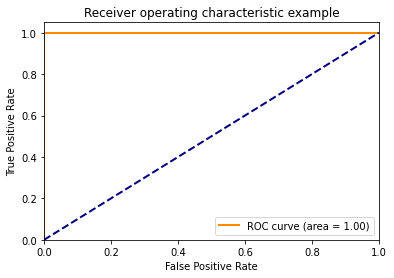

In [22]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % AUC)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [23]:
fpr

array([0., 0., 0., 1.])

In [24]:
tpr

array([0.   , 0.125, 1.   , 1.   ])

In [25]:
thresholds

array([1.9999987e+00, 9.9999869e-01, 8.2671934e-01, 2.4304693e-04],
      dtype=float32)

In [26]:
# metrics.plot_roc_curve(clf, X_test, y_test)  
# plt.show()                           

### feature extracted at the last layer

In [27]:
# # output of last layer
# feature_extractor = tf.keras.Model(
#     inputs=model.inputs,
#     outputs=model.get_layer(name="feature_extraction").output,
# )

# train_features = feature_extractor(np.transpose(np.reshape(train_data, [-1, n_features, motor.data_dim_MFCC]), [0, 2, 1]))
# test_features = feature_extractor(np.transpose(np.reshape(test_data, [-1, n_features, motor.data_dim_MFCC]), [0, 2, 1]))
# whole_features = feature_extractor(np.transpose(np.reshape(data_whole, [-1, n_features, motor.data_dim_MFCC]), [0, 2, 1]))

In [28]:
# whole_features

In [29]:
# train_features

In [30]:
# train_label

In [31]:
# test_features

In [32]:
# test_label

In [33]:
# np.savetxt("feature_extraction_MFCConly_whole.txt",whole_features)

In [34]:
# # Make a model with 2 layers
# layer1 = tf.keras.layers.Dense(3, activation="relu")
# layer2 = tf.keras.layers.Dense(3, activation="sigmoid")
# model = tf.keras.Sequential([tf.keras.Input(shape=(3,)), layer1, layer2])

# # Freeze the first layer
# layer1.trainable = False

# print("weights:", len(layer1.weights))
# print("trainable_weights:", len(layer1.trainable_weights))
# print("non_trainable_weights:", len(layer1.non_trainable_weights))

# # Keep a copy of the weights of layer1 for later reference
# initial_layer1_weights_values = layer1.get_weights()

# # Train the model
# model.compile(optimizer="adam", loss="mse")
# model.fit(np.random.random((2, 3)), np.random.random((2, 3)))

# # Check that the weights of layer1 have not changed during training
# final_layer1_weights_values = layer1.get_weights()
# np.testing.assert_allclose(
#     initial_layer1_weights_values[0], final_layer1_weights_values[0]
# )
# np.testing.assert_allclose(
#     initial_layer1_weights_values[1], final_layer1_weights_values[1]
# )

In [35]:
# plot SVM

# svm.__dict__